C:\Users\Peter\AppData\Local\Temp\ipykernel_17900\2960970509.py:12: DtypeWarning: Columns (3443,3444,3445,3446,3447,3448,3449,3450,3451,3452,3453,3454,3455,3456,3457,3458,3459,3460,3461,3462,3463,3464,3465,3466,3467,3468,3469,3470,3471,3472,3473,3474,3475,3476,3477,3478,3479,3480,3481,3482,3483,3484,3485,3486,3487,3488,3489,3490,3491,3492,3493,3494,3495,3496,3497,3498,3499,3500,3501,3502,3503,3504,3505,3506,3507,3508,3509,3510,3511,3512,3513,3514,3515,3516,3517,3518,3519,3520,3521,3522,3523,3524,3525,3526,3527,3528,3529) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('D:/softwares/code/python/pycharm/Prot+Met-Age_Clock/Data/1.heal_prot+met+pop+diea+age.csv')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.364823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 809131
[LightGBM] [Info] Number of data points in the train set: 12862, number of used features: 3174
[LightGBM] [Info] Start training from score 54.759528


C:\Users\Peter\AppData\Local\Temp\ipykernel_17900\2960970509.py:100: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


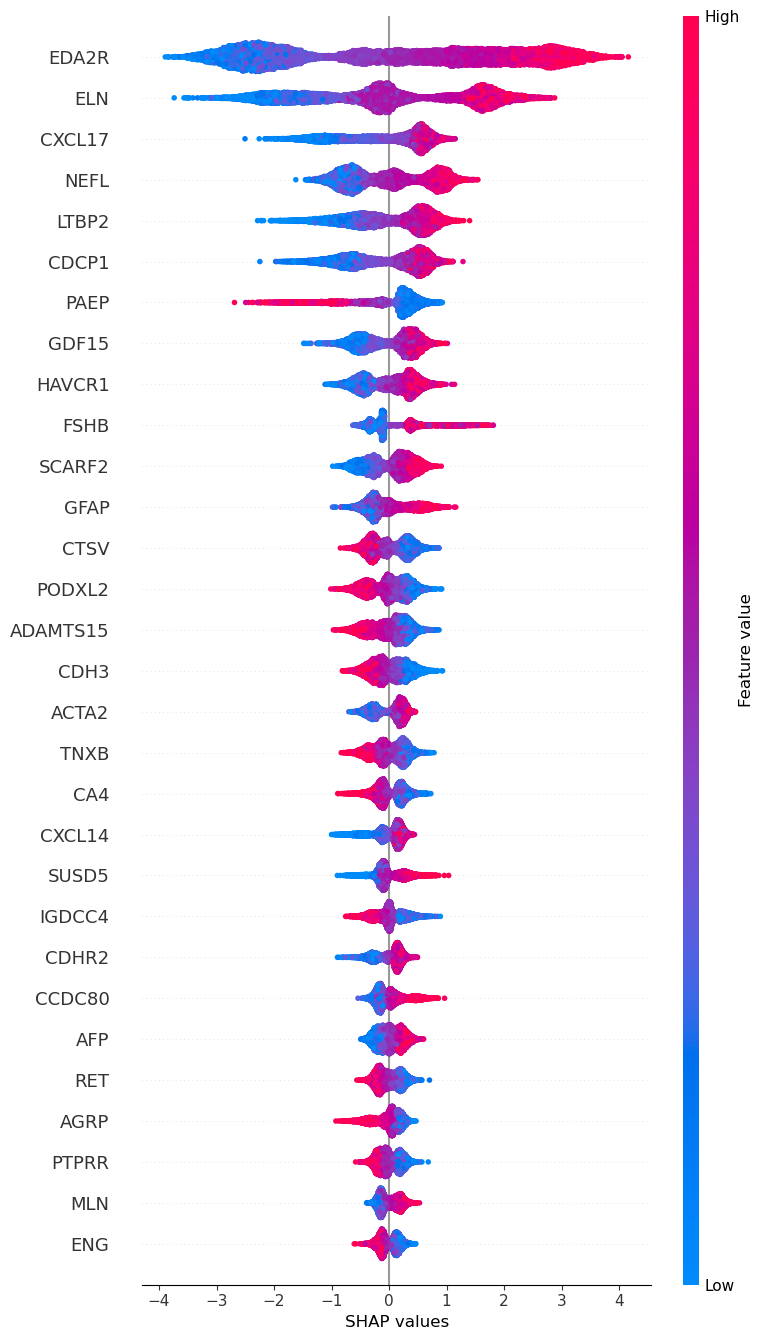

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.colorbar import Colorbar
from sklearn.model_selection import train_test_split

# Load main dataset
data = pd.read_csv('../../Model/Prot+Met-Age_Clock/Data/1.heal_prot+met+pop+diea+age.csv')

# Load protein ID to name mapping file
mapping_df = pd.read_csv('../../Fig 5/data/olink_data_coding143.csv')

# Create dictionary to map protein IDs to their names
protein_id_to_name = dict(zip(mapping_df['coding'].astype(str), mapping_df['meaning']))

# Extract features
X = data.iloc[:, 1:3175]
y = data.iloc[:, -1]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LightGBM regression model
model = lgb.LGBMRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Create SHAP explainer and calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Calculate mean absolute SHAP values for each feature
shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
})

# Select top 30 most important features
top_30 = shap_importance.nlargest(30, 'Importance')

# Feature Name Conversion
def convert_feature_name(feature):
    str_feature = str(feature)
    if feature.isdigit() and 1 <= int(feature) <= 2924:
        return protein_id_to_name.get(str_feature, f"Prot_{feature}")
    return feature

# Apply name conversion to top features
top_30['Feature_Name'] = top_30['Feature'].apply(convert_feature_name)

# Get original feature names and their indices
original_features = top_30['Feature'].values
feature_indices = [X_train.columns.get_loc(f) for f in original_features]

# Extract SHAP values and feature values for top features
shap_top_values = shap_values[:, feature_indices]
X_top = X_train[original_features].copy()
X_top.columns = top_30['Feature_Name'].values

# Create SHAP Summary Plot
plt.figure(figsize=(10, 5))

# Generate SHAP summary plot for top 30 features
shap.summary_plot(
    shap_top_values,
    X_top,
    feature_names=top_30['Feature_Name'].values,
    plot_type="dot",
    max_display=30,
    show=False
)

# Get current axes for customization
ax = plt.gca()
ax.set_xlabel("SHAP values", fontsize=12)

# Find the colorbar object in the plot
cbar = None
for child in ax.get_children():
    if isinstance(child, Colorbar):
        cbar = child
        break

# Customize colorbar label if found
if cbar:
    # Remove default label
    cbar.ax.set_ylabel('')
    # Add custom rotated label
    cbar.ax.text(1.8, 0.5, 'Variable Value', 
                rotation=180,
                va='center',
                ha='center',
                transform=cbar.ax.transAxes,
                fontsize=15)

# Adjust layout and display plot
plt.subplots_adjust(left=0.4)
plt.tight_layout()
plt.show()